In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

# Problem 1

### Single step integrator

`rk4_step` is a single step RK4 integrator adapted from Jon's RK4 code in his slides on ODEs.

Given that the analytical solution is $y = c_0 e^{arctan(x)}$, and the initial condition of $y(-20) = 1$, we can find the actual solution to be $y = 4.58 e^{arctan(x)}$. 

Below is the plot of the residuals. My integrator behaves nicely when $x < 0$, but the error grows when $x > 0$.

In [2]:
#analytic solution
c = 1/np.exp(np.arctan(-20))
print('c0 =',c)

c0 = 4.576058010298909


In [3]:
def rk4_step(fun,x,y,h):
    k1 = h*fun(x,y)
    k2 = h*fun(x+h/2,y+k1/2)
    k3 = h*fun(x+h/2,y+k2/2)
    k4 = h*fun(x+h,y+k3)
    
    dy = (k1 + 2*k2 + 2*k3 + k4)/6
    
    return y+dy

In [4]:
def fun(x,y):
    return y/(1+x**2)
    
nsteps = 200
x = np.linspace(-20,20,nsteps)
y = np.zeros(nsteps)
y[0] = 1
y[1] = 0

for n in range(nsteps-1):
    h = x[n+1] - x[n]
    y[n+1] = rk4_step(fun,x[n],y[n],h)

Variance = 3.02354088952565e-08


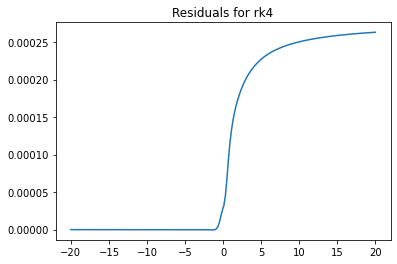

In [21]:
real_soln = c*np.exp(np.arctan(x))
plt.title('Residuals for rk4')
plt.plot(x,real_soln-y)

print(f'Variance = {np.std((real_soln-y)**2)}')

### Modified step integrator

Following section 17.2 in _Numerical Methods_, we can take two half steps in our RK4 integrator from the previous step (call this $y_2$), and compare this with a single step (call this $y_1$).

So for each step:

$y(x+h) = y_1 + (2h)^5\phi + O(6) + ...$\
$y(x+h) = y_2 + 2(h)^5\phi + O(6) + ...$

If we subtract these equations, we can eliminate the O(6) term, and our truncation error becomes:\
$\Delta = y_2 - y_1$.

And the estimate for our full solution becomes $y(x+h) = y_2 + \frac{\Delta}{15} + O(h^6)$ - since we have no way of estimating the truncation error on this, so we use $\frac{\Delta}{15}$ as our error estimate.

The integrator works by first taking the step of size h to $x = x + h$ (defined as the difference between x values), and then takes one half step to $x = x+\frac{h}{2}$, then takes another half step to $x = x + h$, using the output from the previous step as the initial $y$ value.

The original rk4 integrator uses 4 function evaluations per step, while the new one uses 12 function calls $\implies$ to get the same number of steps, we need to multiply `nsteps` by a factor of 3.

We can see that the variance is smaller by $\approx$ an order of magnitude, so for the same number of function calls, we get a more accurate result.

In [17]:
def rk4_stepd(fun,x,y,h):
    step = rk4_step(fun,x,y,h) #4 function calls
    one_half_step = rk4_step(fun,x,y,h/2) #3 function calls
    two_half_steps = rk4_step(fun,x+h/2,one_half_step,h/2) #4 function calls
    
    delta = two_half_steps - step
        
    return two_half_steps+delta/15

In [18]:
nsteps_new = int(200/3)
x_new = np.linspace(-20,20,nsteps_new)
y_adaptive = np.zeros(nsteps_new)
err = np.zeros(nsteps_new)
y_adaptive[0] = 1
y_adaptive[1] = 0

for n in range(nsteps_new-1):
    h = x_new[n+1] - x_new[n]
    y_adaptive[n+1] = rk4_stepd(fun,x_new[n],y_adaptive[n],h)

Variance = 7.391513374857224e-09


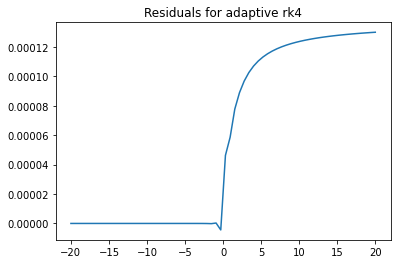

In [20]:
c = 1/np.exp(np.arctan(-20))
real_soln_new = c*np.exp(np.arctan(x_new))

print(f'Variance = {np.std((real_soln_new-y_adaptive)**2)}')

plt.title('Residuals for adaptive rk4')
plt.plot(x_new,real_soln_new-y_adaptive)

# Problem 2

I adapted the method for `deriv` from this website but made the long return statement into a for loop to make it a bit easier to read/debug: https://scipython.com/book2/chapter-8-scipy/problems/p82/modelling-a-radioactive-decay-chain/. The half lives come from Jon's ODE powerpoint slide.

Essentially, the amount of each substance is $growth\ rate - decay\ rate$, where the growth rate is given by the decay rate of the element before it in the decay chain. The decay rate is given by $\frac{y}{t_{half}}$, where y is the amount of species left, and ${t_{half}}$ is the half life, where in my code, `k` is $\frac{1}{t_{half}}$. The decay coefficient for Pb-206 is set to zero (inverse of `np.inf`) because it is stable, so it does not produce decay products and its quantity depends only on the decay of Po-210.

This code calculates the derivative $\frac{dx}{dt}$ of each species at each time step by using scipy's `integrate.solve_ivp`. Since this is a stiff set of equations (i.e., some species require very small steps because they have short half lives, but this will result in a very long running time for species with longer half lives, or vice versa, where it will just crash) we use the Radau method, which is optimized for stiff systems of equations.

My y array is set up such that the array elements are:\
`y[0]` = U-238\
`y[1]` = Th-234\
`y[2]` = Pr-234\
`y[3]` = U-234\
`y[4]` = Th-230\
`y[5]` = Ra-226\
`y[6]` = Rn-222\
`y[7]` = Po-218\
`y[8]` = Pb-214\
`y[9]` = Bi-214\
`y[10]` = Po-214\
`y[11]` = Pb-210\
`y[12]` = Bi-210\
`y[13]` = Po-210\
`y[14]` = Pb-206

In [586]:
#initial conditions
y0 = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

#half lives
t_half = np.array([(4.468e9)*(3.154e7),24.10*86400,6.7*3600,245500*(3.154e7),75380*(3.154e7),1600*(3.154e7),3.8235*86400,3.1*60,26.8*60,19.9*60,164.3/(1e6),22.3*(3.154e7),5.015*(3.154e7),138.376*86400,np.inf])
k = 1/t_half #rate coefficients

def deriv(t,y): #dx/dt for each species
    dydt = np.zeros(len(y0))
    
    dydt[0] = -y[0]*k[0]
    
    for i in range(len(dydt)-1):
        dydt[i+1] = y[i]*k[i] - y[i+1]*k[i+1]
        
    return dydt

t = 1e18 

ans_stiff=integrate.solve_ivp(deriv,(0,t),y0,method='Radau')

### Plot the ratio of Pb206 to U238

Analytically, this is what I expect, since we can approximate that U-238 decays directly into U-238, so we should see an exponential relationship between the two: as we have small amounts of U-238 decaying into Pb-206, we will have a rate of ~0. After a significant amount of time has passed, we will only have trace amounts of U-238 remaining, so the ratio will blow up.

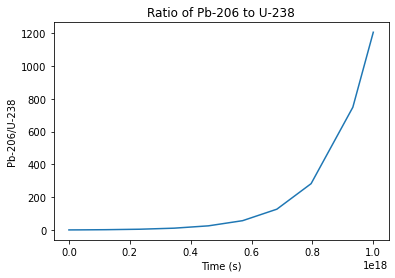

In [587]:
u238 = ans_stiff.y[0]
pb206 = ans_stiff.y[-1]

ratio = pb206/u238

plt.plot(ans_stiff.t,ratio)
plt.title('Ratio of Pb-206 to U-238')
plt.xlabel('Time (s)')
plt.ylabel('Pb-206/U-238')
plt.show()

### Ratio of Th-230 to U-234

U-234 decays into Th-230, and they both have similar half lives. Initially, we will have larger amounts of U-234, since it is produced by Pr-234 with a half life on the scale of hours (i.e., << half life of U-234 and Th-230), but this will become stable fairly quickly due to the similar decay rates of each species (i.e., the amount of Th-230 decaying into U-234 $\approx$ the amount of U-234 decaying into Ra-226)

/var/folders/dg/7jl6bkpj645c5wgdkkh7h8zw0000gn/T/ipykernel_38698/1598546547.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ans_stiff.t,th230/u234)


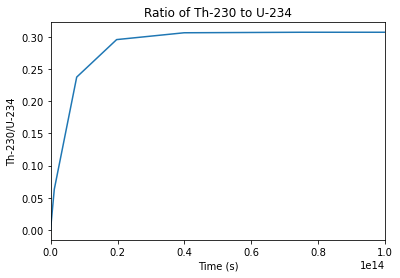

In [607]:
u234 = ans_stiff.y[3]
th230 = ans_stiff.y[4]

plt.plot(ans_stiff.t,th230/u234)
plt.xlim(0,1e14)
plt.title('Ratio of Th-230 to U-234')
plt.xlabel('Time (s)')
plt.ylabel('Th-230/U-234')
plt.show()

# Problem 3

### a) Reparameterize the paraboloid to get a linear equation

The original equation for the paraboloid is $z-z_0 = a[(x-x_0)^2 + (y-y_0)^2]$.

We can expand and rearrange terms to get $z = a(x^2+y^2) - 2ax_0x -2ay_0y + a(x_0^2+y_0^2+z_0)$

Now our parameters are $a(x^2+y^2$), $-2ax_0x$, $-2ay_0y$, and $a(x_0^2+y_0^2+z_0)$.

So our model parameters are $a$, $-2ax_0$, $-2ay_0$, and $a(x_0^2+y_0^2+z_0)$, and our A matrix looks like:\
`A[:,0]` = $x^2+y^2$\
`A[:,1]` = $x$\
`A[:,2]` = $y$\
`A[:,3]` = 1

### b) Find the best fit parameters for the data

Linear least squares: $A^TN^{-1}Am = A^TN^{-1}d$

Cancel out $N^{-1}$ terms: $A^TAm = A^Td$

$\implies m = A^Td(A^TA)^{-1} = $ RHS/LHS 

We know from above that:\
`m[0]` = $a$\
`m[1]` = $-2ax_0$\
`m[2]` = $-2ay_0$\
`m[3]` = $a(x_0^2 + y_0^2 + z_0)$

So we can solve these equations to get the original parameters we wanted:\
$a = m[0]$\
$x_0 = \frac{m[1]}{-2m[0]}$\
$y_0 = \frac{m[2]}{-2m[0]}$\
$z_0 = \frac{m[3]}{m[0]} - [\frac{m[1]}{-2m[0]}]^2 - [\frac{m[2]}{-2m[0]}]^2$

In [221]:
x,y,z = np.genfromtxt('dish_zenith.txt',unpack=True)

A=np.empty([len(x),4])

A[:,0] = x**2 + y**2
A[:,1] = x
A[:,2] = y
A[:,3] = np.ones(len(x))

lhs = A.T@A
rhs = A.T@z

m = np.linalg.inv(lhs)@rhs

a = m[0]
x0 = m[1]/(-2*a)
y0 = m[2]/(-2*a)
z0 = m[3]/a - x0**2 -y0**2

In [199]:
print(f'Parameters are: a = {a}, x0 = {x0}, y0 = {y0}, z0 = {z0}')

Parameters are: a = 0.0001667044547740144, x0 = -1.3604886221977734, y0 = 58.22147608157947, z0 = -9075205.651148656


### c) Predict noise and error bars

Residuals of this fit (z-pred) are the model for our noise, and we can use the standard deviation of the resiuals as our noise estimate. 

The errors in the parameters are calculated by taking the square root of the diagonal of the covariance matrix. For us, the covariance matrix is just the inverse of the LHS. This code was adapted from Jon's `fit_tempdata_class.py`

In [508]:
pred = A@m

noise = np.std(z-pred)

print(f'Noise estimate is {noise} mm')

N=np.std(z-pred)**2

param_err = np.sqrt(np.diag(np.linalg.inv(lhs)))

print(f'Uncertainty in a is: {param_err[0]}')

Noise estimate is 3.768338648784731 mm
Uncertainty in a is: 1.7121337434320508e-08


### Focal length calculation

Focal length is based off of a paraboloid centered at (0,0). If we move our paraboloid to (0,0,0), we can ignore all the constants except $a$, giving us $z = a(x^2+y^2)$. For a 3D paraboloid, the focal point is located at $z = \frac{x^2+y^2}{4f}$ (substitute $z = y$ and $x^2 + y^2 = x^2$ to add the extra dimension).

If we equate these two expressions, we can cancel the $x$ and $y$ terms to get $f = \frac{1}{4a}$, so our focal point is only dependent on $a$.

Since there is uncertainty in $a$, we will do a first order Taylor expansion to consider this:
$\Delta f \approx \frac{1}{4a^2}\Delta a$, where $\Delta a$ is the uncertainty on $a$ we calculated above (`model_err[0]`).

Since x,y,z are in mm, I divide by 1000 to get units of m to compare with the expected focal length of 1.5m. My answer is relatively consistent, especially when taking into account machine precision.

In [506]:
f = 1/(4*a)/1000.
err_f = ((1/(4*a**2))*param_err[0])/1000.

print(f'Focal length is {f} +/- {err_f} m')

Focal length is 1.4996599841252087 +/- 0.0001540221865082264 m
